In [3]:
using Distributions 
using PyPlot

#### Generate data 
Generate toy-data that has location information .
k signal clusters along a 2 dimensional  
n by n grid 


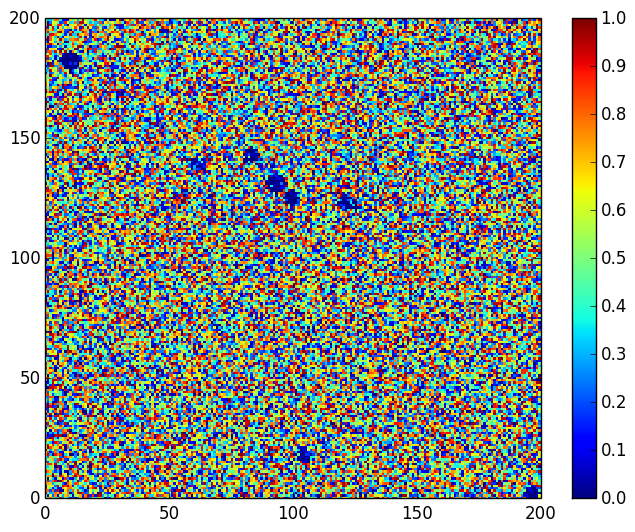

PyObject <matplotlib.colorbar.Colorbar instance at 0x3320fae60>

In [1184]:
#k clusters of signals, the rest are all null   

#point = (xloc, yloc, p-value)
n = 200; 
k = 10; 

null_dist = Uniform(0,1);
dataSet = zeros(n,n);

#generate k centers randomly
center_vec = Tuple{Int,Int}[]
for(i in 1:k)
    center = (rand(DiscreteUniform(1,n)), rand(DiscreteUniform(1,n)));
    while(center in center_vec) center = (rand(DiscreteUniform(1,n)), rand(DiscreteUniform(1,n))); end
    push!(center_vec, center); 
end

#generate k Beta distributions randomly 
betas = Float64[];
#alpha = 1/beta so only need to store one parameter
for(i in 1:k)
    push!(betas, rand(Uniform(2,10)))
end



#given the center of a cluster 
#returns the points associated with the circle 
#uses bruteforce
function getCluster(center, n, radius)
    x0 = center[1];
    y0 = center[2];   
    cluster = Tuple{Int,Int}[];
    for(y in -radius:radius)
        for(x in -radius:radius)
            if(x*x + y*y <= radius*radius)
                push!(cluster, (x0 + x, y0 + y))
            end
        end
    end
    return cluster; 
end
    

#generate k clusters with randomly generated radius 
cluster_arr = Array{Tuple{Int,Int},1}[];
for(i in 1:k)
    radius = round(rand(TruncatedNormal(4,4,1,4)));
   # radius = round(n/8);
    push!(cluster_arr, getCluster(center_vec[i], n, radius))
end


#generate dataset
for(i in 1:n)
    for(j in 1:n)
        is_null = true;
        for(z in 1:k)
            cluster = cluster_arr[z];
            beta = betas[z];
            beta_dist = Beta(1/beta,beta);
            if((i,j) in cluster)
                is_null = false; 
                dataSet[i,j] = rand(beta_dist);
            end
        end
        if(is_null) dataSet[i,j] = rand(null_dist); end
    end
end
pcolormesh(dataSet)
colorbar()



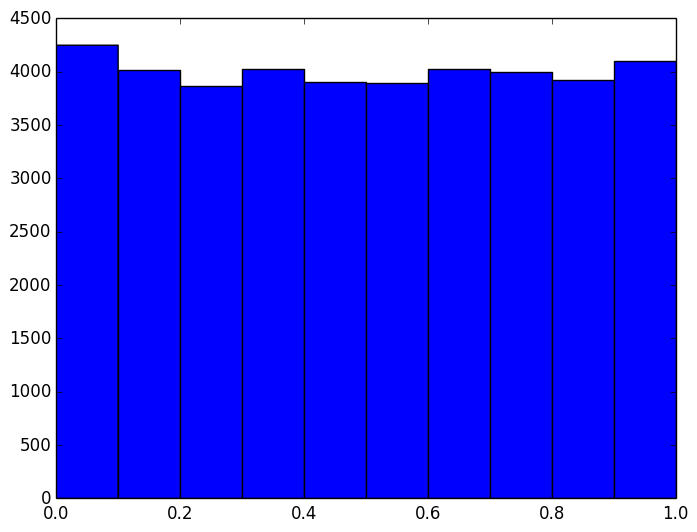

([4249.0,4018.0,3864.0,4022.0,3900.0,3897.0,4030.0,3994.0,3927.0,4099.0],[2.381177199688822e-16,0.0999941316503124,0.19998826330062458,0.2999823949509367,0.3999765266012489,0.49997065825156106,0.5999647899018732,0.6999589215521854,0.7999530532024975,0.8999471848528097,0.9999413165031219],Any[PyObject <matplotlib.patches.Rectangle object at 0x32d264790>,PyObject <matplotlib.patches.Rectangle object at 0x32d264dd0>,PyObject <matplotlib.patches.Rectangle object at 0x32d25d490>,PyObject <matplotlib.patches.Rectangle object at 0x32d25db10>,PyObject <matplotlib.patches.Rectangle object at 0x32d25c1d0>,PyObject <matplotlib.patches.Rectangle object at 0x32d25c850>,PyObject <matplotlib.patches.Rectangle object at 0x32d25ced0>,PyObject <matplotlib.patches.Rectangle object at 0x327c90250>,PyObject <matplotlib.patches.Rectangle object at 0x327c90410>,PyObject <matplotlib.patches.Rectangle object at 0x327c822d0>])

In [1185]:
data = reshape(dataSet,n*n) #reshapes along column 
locations = Tuple{Int,Int}[]; 
for(i in 1:n)
    for(j in 1:n)
        push!(locations, (j,i))
    end
end
#verify that it did the right thing 
for(z in 1:(n*n))
    loc = locations[z];
    x = loc[1];
    y = loc[2]; 
   if(dataSet[x,y] != data[z])
        println(x,y)
    end
end
plt[:hist](data)


Similar algorithm to Stephens paper 
Assume data is generated according to a mixture model which incorporates location information. 


1. Sample number of signal clusters and labels by running birth-death process

3. Sample betas of signal clusters with everything else fixed 






Initialize parameters and prior distributions:

In [1186]:
##### initialize parameters and prior distributions 
#prior distributions on parameters

#prior distribution on beta
mu = 10; 
sigma = 5; 
Beta_priordist = TruncatedNormal(mu, sigma, 5, 200);

#prior distribution on number of signal clusters
Clusters_priordist = Truncated(Poisson(100), 1, 100)

#initial number of clusters
num_clusters = 2; #number of signal clusters

#prior distribution on labels (bit more complicated than this when we incorporate location info)
#labels_prior = DiscreteUniform(1,num_clusters);


#initialize rest of parameters
labels = ones(length(data)); #start with assumption whole model is null 

#to do put prior on radius 
radius_prior = TruncatedNormal(5, 2, 2,100); 

#store clusters and their radiuses in vector
array_of_clusters = Array{Tuple{Int64,Int64},1}[];  
array_of_radius = Float64[]; 


for(i in 1:num_clusters)
    radius = round(rand(radius_prior)); 
    point = rand(DiscreteUniform(1,length(data)));
    center = locations[point]; 
    newCluster = getCluster(center, n, radius);
    for(point in newCluster)
        index = find(locations .== point);
        labels[index] = i+1; #since label 1 is the null label this new label
    end
    push!(array_of_radius, radius);
    push!(array_of_clusters, newCluster);
end


#store the clusters in a vector 


#add null cluster to beginning 
b_arr = [1]; 
b_arr = [b_arr; rand(Beta_priordist,num_clusters)]; #beta distribution parameters




3-element Array{Float64,1}:
  1.0    
  6.02351
 13.0307 

Run birth-death process to get cluster labels. 

In [1187]:
#birth death-chain to sample labels 


#birth rate 
birth_rate = 1;
curr_time = 0; 
t_0 = 1000; 

##keep last K labels 
K = 100; 

label_arr = zeros(length(data), K); 

#distribution of signal betas
bcurr_arr = b_arr[2:end];
for(idx_1 in 1:10000)
    while(curr_time < t_0)
       # if(length(labels > length(data))) break; end;
        delta_arr = zeros(num_clusters);
        #append null 
        b_dist = [Beta(1/b,b) for b in [1; bcurr_arr]];

        #calculate log-likelihood of current model
        l_y = 0; 
        for(idx_2 in 1:(num_clusters+1))
            cluster = data[labels .== idx_2];
            if(length(cluster) > 0)
                l_y = l_y + loglikelihood(b_dist[idx_2], cluster);
            end
        end
        c_y = loglikelihood(Clusters_priordist, [num_clusters]);

        #calculate death rate of component j
        for(idx_3 in 1:num_clusters)
            b_arr_death = copy(bcurr_arr);
            label_death = deepcopy(labels);
            deleteat!(b_arr_death, idx_3);
            label_death[labels.== idx_3+1] = 1; #turn those labels back to signals 

            #calculate log likelihood after death
            ldy = 0; 
            for(idx_4 in 1:(num_clusters+1))
                cluster = data[label_death .== idx_4];
                if(length(cluster) > 0)
                    ldy = ldy + loglikelihood(b_dist[idx_4], cluster);
                end
            end 
            c_yd = loglikelihood(Clusters_priordist, [num_clusters-1]);
            delta_arr[idx_3] = log(lambda) + (ldy - l_y) + (c_yd - log(num_clusters) - c_y); 
        end
        death_rate = sum(exp(delta_arr)); 

        #simulate time to next birth/death from an exponential distribution 
        #with mean: birth_rate + death_rate
        t = 1/rand(Exponential(birth_rate + exp(death_rate)));
        curr_time = curr_time + t; 
        if(curr_time < t_0) #then we have a birth or a death 
            #flip a weighted coin to determine birth or death 
            is_birth = rand(Bernoulli(birth_rate/(birth_rate + death_rate)));
            if(is_birth == 1)#we have a birth 
                #simulate the point at which birth takes place 
                #to do put more informative prior on this
                point = rand(DiscreteUniform(1,length(data)));
                radius = rand(radius_prior)
                overlap = true;
                while(overlap)
                #avoid clusters that overlap with already formed clusters
                    point = rand(DiscreteUniform(1,length(data)));
                    radius = round(rand(radius_prior));
                    overlap = false;
                    newCluster = getCluster(locations[point], n, radius)
                    for(loc in newCluster)
                        index = find(locations .== loc);
                        if(length(index) > 0)
                            index = index[1]; 
                            if(labels[index] != 1) overlap = true; #println(index); break;
                            end
                        end
                    end
                    if(overlap == false) 
                        push!(array_of_clusters, newCluster)
                        push!(array_of_radius, radius)
                    end;
                end
                
                    
                #care about overlapping clusters
                #since this messes up algorithm 

                newCluster = array_of_clusters[end];
                for(point in newCluster)
                    index = find(locations .== point);
                    new_label = num_clusters + 2; 
                    labels[index] = new_label; 
                end

                #simulate the beta parameter associated with 
                #this cluster from the prior
                b = rand(Beta_priordist)

                #update parameter vectors
                push!(bcurr_arr, b)
                num_clusters = num_clusters + 1; 

            else #we have a death 
                #select a component to die by sampling from a 
                #categorical distribution with vector delta_arr/death_rate
                sure_deaths = find(delta_arr .> 50);
                if(length(sure_deaths) > 0) #for computational issue
                    #println("die!")
                    death_j = sure_deaths[1];
                else
                   # println(vec(exp(delta_arr)./death_rate));
                    death_j = rand(Categorical(vec(exp(delta_arr)./death_rate)));
                end

                #update parameter vectors
                deleteat!(bcurr_arr, death_j);
                deleteat!(array_of_clusters, death_j);
                deleteat!(array_of_radius, death_j)
                labels[labels.== death_j+1] = 1; 
                for(z in (death_j+2):(num_clusters+1))
                    #println(z);
                    labels[labels.==z] = z-1; 
                end
                num_clusters = num_clusters - 1; 
            end
        end
    end
    label_arr[:, idx_1%K+1] = labels; 
end
b_arr = vec([1; bcurr_arr]);
println(b_arr)


[1.0,9.763346592965146]


In [1189]:
labels = vec(round(mean(label_arr,2)));


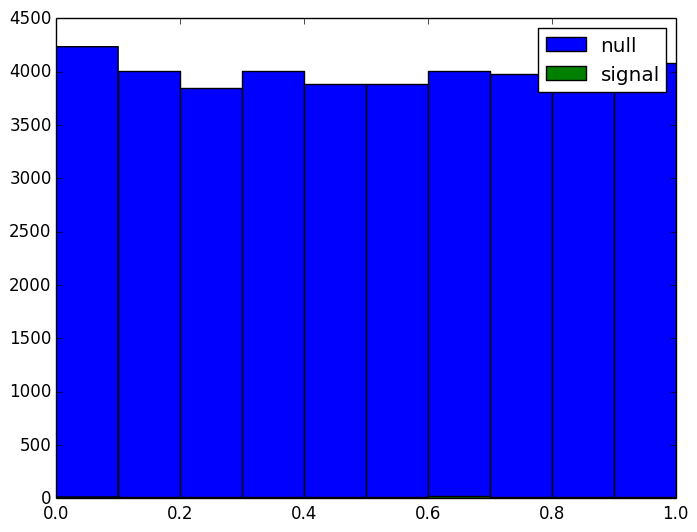

In [1190]:
plt[:hist](data[find(labels.==1)], label = "null") #data associated with null cluster
plt[:hist](data[find(labels.!=1)], label = "signal") #data associated with signals 
legend();

Metropolis hastings to sample mixture proportions and beta. 

In [1191]:
#given proposal returns the step that metropolis chooses
function getMetropolisStep(prop, curr, prior_dist, curr_dist, prop_dist, data)
    n = length(data)
    likelihood_current = loglikelihood(curr_dist, data);
    likelihood_prop = loglikelihood(prop_dist, data); 

    prior_current = log(pdf(prior_dist, curr));
    prior_prop = log(pdf(prior_dist, prop));

    p_curr = likelihood_current+prior_current;
    p_prop = likelihood_prop+prior_prop;

    p_accept = exp(p_prop-p_curr); 

    #flip a p-weighted coin to determine whether we accept the change
    if(rand() < p_accept)
        return prop; 
    end
    return curr; 
end


getMetropolisStep (generic function with 1 method)

In [1192]:
for(curr_label in 1:num_clusters)
    for(i in 1:1000)
        prop_width = 0.1
        #proposed betas are random step away from each beta
        b_prop = rand(Normal(bcurr_arr[curr_label], prop_width));
        while(b_prop < 1)  b_prop = rand(Normal(bcurr_arr[curr_label], prop_width)); end;
        curr_dist = Beta(1/bcurr_arr[curr_label], bcurr_arr[curr_label]); 
        prop_dist = Beta(1/b_prop, b_prop); 
        cluster = data[find(labels .== curr_label)];
        bcurr_arr[curr_label]  = getMetropolisStep(b_prop, bcurr_arr[curr_label],Beta_priordist,curr_dist, prop_dist,cluster);
    end
end  
bcurr_arr

LoadError: InterruptException:

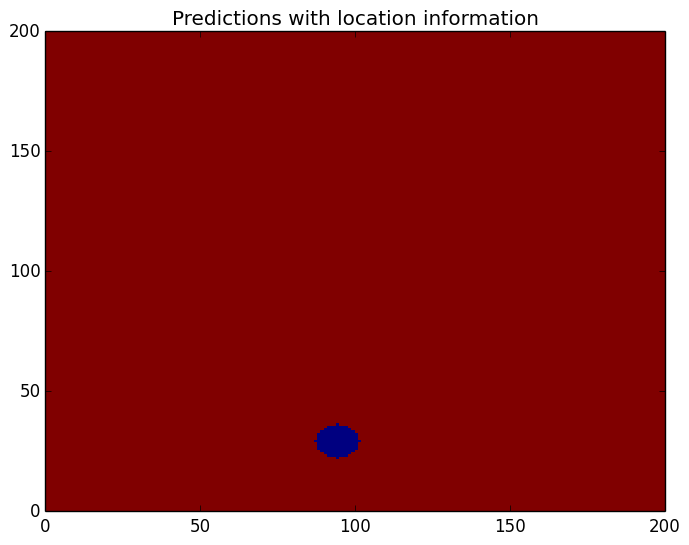

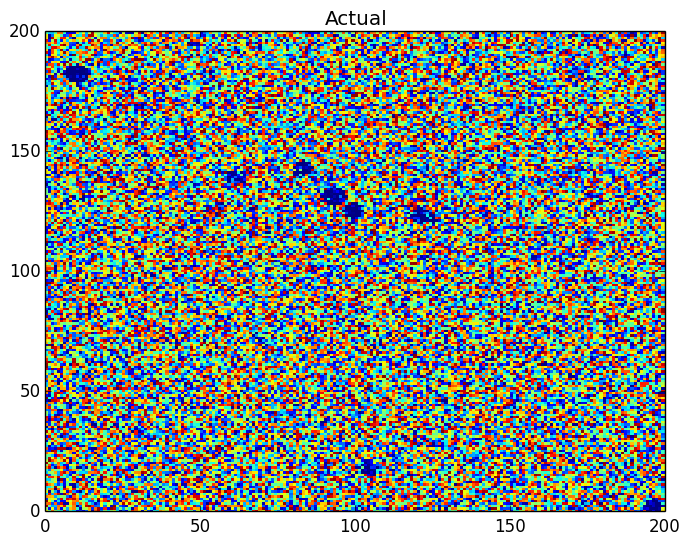

In [1193]:
##plot predictions 
ddd = copy(data);
ddd[labels.==1] = 1; 
ddd[labels.!=1] = 0; 
dddd = reshape(ddd,n,n);
figure();
title("Predictions with location information");
pcolormesh(dddd);
figure();
title("Actual")
pcolormesh(dataSet);


In [985]:
num_clusters

8